Install Libs

In [ ]:
# чухал libraries суулгах
!pip -q install -U "transformers>=4.44.0" "datasets>=2.19.0" "peft>=0.13.0" \
  "accelerate>=0.34.0" "bitsandbytes>=0.43.0" "evaluate>=0.4.2" "rouge-score>=0.1.2"

import torch, platform, sys
print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected")

MODEL_NAME   = "bayartsogt/mongolian-gpt2"
DATASET_NAME = "amaraaa/mn_translated_cnn_extended"


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 18.0 MB/s eta 0:00:00
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


Load model/tokenizer, enable LoRA (FP16), and build a clean preprocessing pipeline (loss only on the summary)

In [ ]:
# STEP 2: Model + Tokenizer + LoRA + Dataset preprocessing
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset

MODEL_NAME   = "bayartsogt/mongolian-gpt2"
DATASET_NAME = "amaraaa/mn_translated_cnn_extended"

# 1) Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.padding_side = "left"
# GPT-2 has no pad; use eos as pad for training
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# FIX: For decoder-only models, set padding_side to 'left' for correct generation
tokenizer.padding_side = "left"

# 2) Base model
dtype = torch.float16 if torch.cuda.is_available() else torch.float32
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=dtype,
)

# Чухал: make model vocab match tokenizer
model.resize_token_embeddings(len(tokenizer))

# Safer attention path for this stack
model.config.attn_implementation = "eager"

model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False

# 3) LoRA
from peft import LoraConfig, get_peft_model, TaskType

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=16,                 # adapter rank (capacity)
    lora_alpha=32,        # scaling
    lora_dropout=0.10,    # regularization
    target_modules=["c_attn", "c_proj"],  # GPT-2 attention projections
    bias="none"
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

if torch.cuda.is_available():
    model.enable_input_require_grads()

if torch.cuda.is_available():
    model.to("cuda")

# 4) Load dataset
ds = load_dataset(DATASET_NAME)

# Quick schema sanity check
sample = ds["train"][0]
print({k: type(v).__name__ for k, v in sample.items()})

# 5) Instruction
# Энэ prompt -ийн дараа хураангуйг generate хийнэ.
INSTRUCTION = (
    "Дараах бичвэрийг хураангуйлж бич."
)
PROMPT_TEMPLATE = (
    "### Даалгавар:\n"
    f"{INSTRUCTION}\n\n"
    "### Бичвэр:\n{article}\n\n"
    "### Хураангуй:\n"
)

# 6) Token-length
MAX_SEQ_LEN      = 1024  # GPT-2 context
TARGET_MAX_TOK   = 160
SOURCE_MAX_TOK   = MAX_SEQ_LEN - TARGET_MAX_TOK

def _join_highlights(x):
    # highlights -> list[str] join into -> single summary string
    if isinstance(x, list):
        return " ".join([s.strip() for s in x if isinstance(s, str) and s.strip()])
    return str(x) if x is not None else ""

def preprocess(example):
    # Extract fields
    article = str(example.get("article", "")).strip()
    summary = _join_highlights(example.get("highlights", []))

    # Build prompt
    prompt_text = PROMPT_TEMPLATE.format(article=article)

    # Tokenize prompt & target
    prompt_ids = tokenizer(
        prompt_text,
        truncation=True,
        max_length=SOURCE_MAX_TOK,
        add_special_tokens=False,
    )["input_ids"]

    # Ensure summary ends with EOS so generation learns to stop
    target_text = summary + tokenizer.eos_token
    target_ids = tokenizer(
        target_text,
        truncation=True,
        max_length=TARGET_MAX_TOK,
        add_special_tokens=False,
    )["input_ids"]

    input_ids = prompt_ids + target_ids
    attention_mask = [1] * len(input_ids)

    # Labels: ignore prompt tokens
    labels = [-100] * len(prompt_ids) + target_ids

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
    }

column_names = ds["train"].column_names
processed = {}
for split in ds.keys():
    processed[split] = ds[split].map(
        preprocess,
        remove_columns=column_names,
        desc=f"Preprocessing {split}",
    )

# 7) Data collator: pad inputs and labels to the same length
from dataclasses import dataclass
from typing import Dict, List, Any

@dataclass
class DataCollatorForCausalSummary:
    tokenizer: Any
    label_pad_token_id: int = -100
    pad_to_multiple_of: int = 8

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        batch_input_ids = [f["input_ids"] for f in features]
        batch_attention = [f["attention_mask"] for f in features]
        batch_labels = [f["labels"] for f in features]

        batch = self.tokenizer.pad(
            {"input_ids": batch_input_ids, "attention_mask": batch_attention},
            padding=True,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        # LEFT- or RIGHT-pad labels to align with tokenizer.padding_side
        max_len = batch["input_ids"].shape[1]
        padded_labels = []
        left = (self.tokenizer.padding_side == "left")
        for l in batch_labels:
            pad_len = max_len - len(l)
            if pad_len < 0:
                # shouldn't happen due to tokenizer.pad, but guard anyway
                l = l[:max_len]
                pad_len = 0
            if left:
                padded = [self.label_pad_token_id] * pad_len + l
            else:
                padded = l + [self.label_pad_token_id] * pad_len
            padded_labels.append(padded)

        batch["labels"] = torch.tensor(padded_labels, dtype=torch.long)
        return batch

data_collator = DataCollatorForCausalSummary(tokenizer)

# 8) Quick sanity check on one batch
from torch.utils.data import DataLoader
tmp_loader = DataLoader(processed["train"].select(range(2)), batch_size=2, shuffle=False, collate_fn=data_collator)
batch = next(iter(tmp_loader))
for k, v in batch.items():
    print(k, tuple(v.shape))

# Decode to visually confirm masking alignment (optional)
def debug_decode(batch, idx=0, n_prompt_tokens_to_show=48):
    ids = batch["input_ids"][idx].tolist()
    labs = batch["labels"][idx].tolist()
    text = tokenizer.decode([t for t in ids if t != tokenizer.pad_token_id])
    print("\n[DECODED TEXT (no pads)]\n", text[:800], "...\n")
    # Show where labels start (first non -100)
    try:
        start = labs.index(next(x for x in labs if x != -100))
        print(f"First supervised token index: {start} / {len(labs)}")
    except StopIteration:
        print("No supervised tokens found in this example (unexpected).")

debug_decode(batch, idx=0)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/864 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 1,622,016 || all params: 126,068,736 || trainable%: 1.2866


README.md:   0%|          | 0.00/606 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/7.08M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/380k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/367k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1862 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/106 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/95 [00:00<?, ? examples/s]

{'id': 'str', 'article': 'str', 'highlights': 'list'}


Preprocessing train:   0%|          | 0/1862 [00:00<?, ? examples/s]

Preprocessing validation:   0%|          | 0/106 [00:00<?, ? examples/s]

Preprocessing test:   0%|          | 0/95 [00:00<?, ? examples/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids (2, 968)
attention_mask (2, 968)
labels (2, 968)

[DECODED TEXT (no pads)]
 ### Даалгавар:
Дараах бичвэрийг хураангуйлж бич.

### Бичвэр:
. Ричард Спиллетт. Машинд цэнэглэж байх үед дэлбэрсэн электрон тамхи нь бүтээгдэхүүний аюулгүй байдлын талаар шинэ айдас төрүүлэв. 54 настай асран хамгаалагч Ким Тейлор машинаас гал болон өтгөн хар утаа гарч байгааг анзаарахаасаа өмнө аравхан минутын турш төхөөрөмжийг цэнэглэж орхижээ. Тухайн үед дотор нь хэн ч байгаагүй ч арын суудал бүрэн хайлж, хоёр хүүхдийн ээж өөрийгөө болон гэр бүлээ гэмтээж магадгүй гэж бодоод маш их айжээ. Видео үзэхийн тулд доош гүйлгэ. Аюулгүй байдлын айдас: Ким Тэйлор болон түүний хүү Жейк 11 настай электрон тамхи дэлбэрсний дараа машиндаа гарсан галыг унтраахаас өөр аргагүй болжээ. 'Би үүнийг залгаад унтсан. өмнө нь "гэж тэр хэлэв. "Хэрэв ийм зүйл тохиолдсон бол юу болох байсан бол гэж бодохоос би үз ...

First supervised token index: 898 / 968


In [ ]:
import numpy as np
from datasets import DatasetDict

# A) Drop examples where the summary produced ZERO supervised tokens (all -100 labels).
def _has_supervised_tokens(ex):
    labs = ex["labels"]
    return any((t != -100) for t in labs)

guarded = {}
for split in processed.keys():
    guarded[split] = processed[split].filter(_has_supervised_tokens, desc=f"Filter empty targets: {split}")

guarded = DatasetDict(guarded)

# B) Sanity-check label ranges (must be -100 or [0, vocab_size-1])
def _sample_label_stats(ds, name, sample=2000):
    V = model.get_output_embeddings().weight.shape[0] - 1  # last valid id
    exs = ds.select(range(min(sample, len(ds))))
    lo, hi, bad = +10**9, -10**9, 0
    total = 0
    for ex in exs:
        for t in ex["labels"]:
            if t == -100:
                continue
            total += 1
            lo = min(lo, t); hi = max(hi, t)
            if t < 0 or t > V:
                bad += 1
    print(f"[{name}] checked={total}, min={None if total==0 else lo}, max={None if total==0 else hi}, "
          f"model_vocab_max={V}, bad={bad}")

for split in guarded.keys():
    _sample_label_stats(guarded[split], split)

# Optional: verify tokenizer vs model sizes
print("len(tokenizer) =", len(tokenizer))
print("model vocab   =", model.get_input_embeddings().weight.shape[0])


# C) Quick length checks
# for split in guarded.keys():
#     lens = [len(x["input_ids"]) for x in guarded[split].select(range(min(1000, len(guarded[split]))))]
#     print(f"[{split}] max seq len in sample:", max(lens) if lens else None)


Filter empty targets: train:   0%|          | 0/1862 [00:00<?, ? examples/s]

Filter empty targets: validation:   0%|          | 0/106 [00:00<?, ? examples/s]

Filter empty targets: test:   0%|          | 0/95 [00:00<?, ? examples/s]

[train] checked=121258, min=5, max=50265, model_vocab_max=50265, bad=0
[validation] checked=7712, min=5, max=50265, model_vocab_max=50265, bad=0
[test] checked=6417, min=5, max=50265, model_vocab_max=50265, bad=0
len(tokenizer) = 50266
model vocab   = 50266


In [ ]:
from torch.utils.data import DataLoader
model.train()
test_loader = DataLoader(guarded["train"].select(range(2)), batch_size=2, shuffle=False, collate_fn=data_collator)

batch = next(iter(test_loader))
for k in batch:
    batch[k] = batch[k].to("cuda" if torch.cuda.is_available() else "cpu")

with torch.autocast(device_type="cuda", dtype=torch.float16) if torch.cuda.is_available() else torch.no_grad():
    out = model(**batch)
    print("Smoke test OK. Loss:", float(out.loss))


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Smoke test OK. Loss: 7.3775482177734375


/tmp/ipython-input-1133197429.py:11: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print("Smoke test OK. Loss:", float(out.loss))


In [ ]:
import random, numpy as np, torch, evaluate
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers.trainer_utils import EvalPrediction
from transformers import EarlyStoppingCallback

# 1) Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

# 2) ROUGE metrics
rouge = evaluate.load("rouge")

def postprocess_text(preds, labels):
    preds = [p.strip() for p in preds]
    labels = [l.strip() for l in labels]
    return preds, labels

def compute_metrics(eval_pred: EvalPrediction):
    preds, labels = eval_pred
    # preds are generated token IDs when predict_with_generate=True
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_preds  = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    r = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {
        "rouge1": round(r["rouge1"] * 100, 2),
        "rouge2": round(r["rouge2"] * 100, 2),
        "rougeL": round(r["rougeL"] * 100, 2),
        "rougeLsum": round(r["rougeLsum"] * 100, 2),
    }

OUTPUT_DIR = "/content/mn-gpt2-sum-lora"
BATCH_TRAIN = 16
BATCH_EVAL  = 16
GRAD_ACC     = 2

args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,
    num_train_epochs=8,
    per_device_train_batch_size=BATCH_TRAIN,
    per_device_eval_batch_size=BATCH_EVAL,
    gradient_accumulation_steps=GRAD_ACC,
    learning_rate=2e-4,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_ratio=0.03,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    # metric_for_best_model="rougeLsum",
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=False,
    report_to="none",
    dataloader_pin_memory=True,
    remove_unused_columns=False,
    gradient_checkpointing=True,
    optim="adamw_torch",
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=guarded["train"],
    eval_dataset=guarded.get("validation", guarded["train"].select(range(200))),
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=None,
)

trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))

# Train
model.config.use_cache = False
train_result = trainer.train()
print("Best ckpt:", trainer.state.best_model_checkpoint)

eval_metrics = trainer.evaluate()
print(eval_metrics)

/tmp/ipython-input-2038755765.py:71: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 50265, 'bos_token_id': 50265, 'pad_token_id': 50265}.


Epoch,Training Loss,Validation Loss
1,6.539700,5.557318
2,5.490100,5.237671
3,5.274700,5.102465
4,5.152600,5.016016
5,5.062300,4.930114
6,4.940600,4.877405
7,4.882300,4.838163
8,4.855700,4.829824


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:309: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:309: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:309: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:309: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:309: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetunin

Best ckpt: /content/mn-gpt2-sum-lora/checkpoint-472


{'eval_loss': 4.829823970794678, 'eval_runtime': 4.1041, 'eval_samples_per_second': 25.828, 'eval_steps_per_second': 1.706, 'epoch': 8.0}


In [ ]:
# === Step 4: ROUGE on validation with clean generation ===
import torch, evaluate
from torch.utils.data import DataLoader

rouge = evaluate.load("rouge")

def _join_highlights(x):
    if isinstance(x, list):
        return " ".join([s.strip() for s in x if isinstance(s, str) and s.strip()])
    return str(x) if x is not None else ""

def build_prompt(article: str) -> str:
    return PROMPT_TEMPLATE.format(article=str(article).strip())

# Use the original validation split
val = ds.get("validation", ds["train"].select(range(800)))

# Optional: limit for a quick pass (e.g., 500). Set to None for full.
MAX_EVAL = None
if MAX_EVAL is not None:
    val = val.select(range(min(MAX_EVAL, len(val))))

articles = [ex["article"] for ex in val]
refs     = [_join_highlights(ex["highlights"]) for ex in val]

preds = []
model.eval()
bs = 16  # adjust if you want to go faster/slower

for i in range(0, len(articles), bs):
    batch_articles = articles[i:i+bs]
    # Encode PROMPT ONLY, truncated to SOURCE_MAX_TOK to leave room for generation
    enc = tokenizer(
        [build_prompt(a) for a in batch_articles],
        padding=True,
        truncation=True,
        max_length=SOURCE_MAX_TOK,      # <= same budget used in training
        add_special_tokens=False,
        return_tensors="pt",
    )
    input_ids = enc["input_ids"].to(model.device)
    attention_mask = enc["attention_mask"].to(model.device)

    with torch.no_grad():
        gen_out = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=160,          # your M budget
            num_beams=4,
            do_sample=False,
            no_repeat_ngram_size=3,
            length_penalty=1.0,
            early_stopping=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    # Slice off the prompt to keep only the continuation per row
    input_lengths = attention_mask.sum(dim=1).tolist()  # true prompt lengths (with left padding)
    for j in range(gen_out.size(0)):
        cont = gen_out[j, input_lengths[j]:]            # continuation only
        text = tokenizer.decode(cont, skip_special_tokens=True).strip()
        preds.append(text)

# Compute ROUGE
preds_clean = [p.strip() for p in preds]
refs_clean  = [r.strip() for r in refs[:len(preds_clean)]]

results = rouge.compute(predictions=preds_clean, references=refs_clean, use_stemmer=True)
print("ROUGE-1 :", round(results["rouge1"]*100, 2))
print("ROUGE-2 :", round(results["rouge2"]*100, 2))
print("ROUGE-L :", round(results["rougeL"]*100, 2))
print("ROUGE-Lsum :", round(results["rougeLsum"]*100, 2))

# (Optional) show a few samples to sanity-check quality
for k in range(3):
    print(f"\n=== Example {k+1} ===")
    print("Pred:", preds_clean[k][:500])
    print("Ref :", refs_clean[k][:500])


ROUGE-1 : 10.06
ROUGE-2 : 3.19
ROUGE-L : 9.74
ROUGE-Lsum : 9.69

=== Example 1 ===
Pred: . Бүх цаг үеийн хамгийн баян тулаан Sky Sports болон тэдний захиалагчдын хувьд хямдхан биш байх болно, хэдийгээр Скай үндсэн үнийг £20-оос доош барьснаараа итгэлээ хадгалсаар байна. Энэ нь Фрэнк Уоррений BoxNation-ийн ширүүн өрсөлдөөнийг зогсоохын тулд Sky-д өгсөн "маш чухал санал" гэж салбарын мэргэжилтнүүдийн тодорхойлсон зүйлийг хүлээж авсан. Флойд Мэйведерийн хүсэн хүлээсэн Мэнни Пакьяотой хийх тулаан Sky Sports сувгаар гарах болно. Пакьяо өмнө нь Лос Анжелес хотод дасгал хийснийхээ дараа то
Ref : Скай Фрэнк Уоррений BoxNation-той ширүүн өрсөлдөөнтэй байсан. Тус нэвтрүүлэгч 300 сая долларын (200 сая фунт стерлинг) тулааныг үзүүлэх эрхийг авсан. Скай Флойд Мэйвезерийн эсрэг Мэнни Пакьяогийн үнийг 19.95 фунт стерлингээр тогтоов. Мега тулаан тавдугаар сарын 2-нд Лас Вегас дахь MGM Grand ордонд болно. Жефф Пауэлл Скайгийн гэрээний тухай мэдээг хэрхэн эвдсэнийг уншина уу.

=== Example 2 ===
Pred: мө

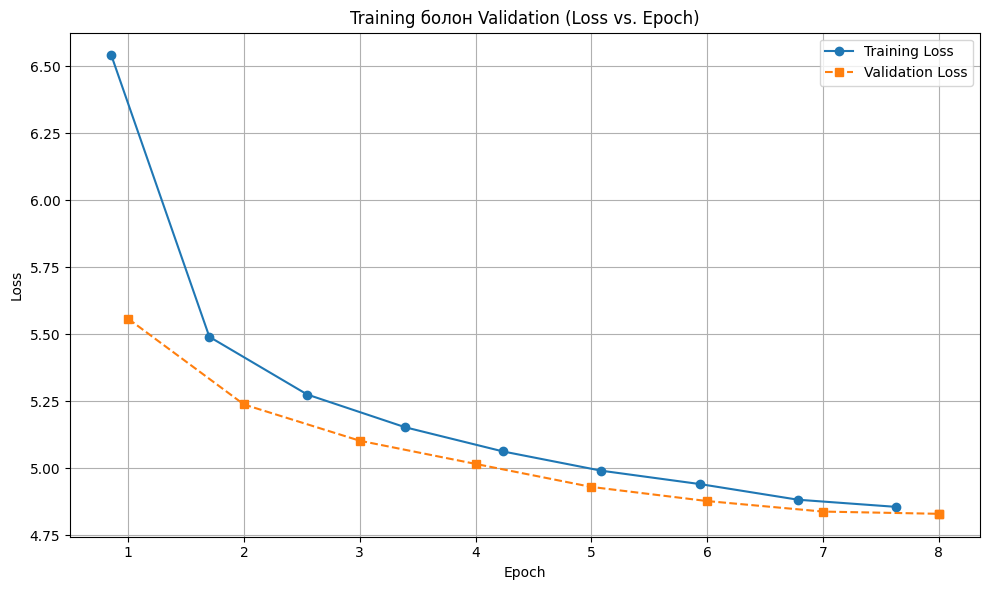

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# fine-tuning дууссаны дараа
def plot_training_loss(trainer):
    """
    Trainer object -ийн history -гоос (training loss/ validation loss) -ийг авах
    """
    # Extract the log history from the trainer state
    history = trainer.state.log_history

    # Convert history list to a pandas DataFrame for easier manipulation
    df = pd.DataFrame(history)

    # Filter for training loss entries
    # The key names might vary slightly ('loss', 'train_loss', 'eval_loss', etc.)
    train_loss_df = df.dropna(subset=['loss'])

    # Filter for validation loss entries
    eval_loss_df = df.dropna(subset=['eval_loss'])

    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot training loss
    if not train_loss_df.empty:
        plt.plot(train_loss_df['epoch'], train_loss_df['loss'], label='Training Loss', marker='o', linestyle='-')

    # Plot validation loss
    if not eval_loss_df.empty:
        # We need to map evaluation steps to the correct epoch values
        plt.plot(eval_loss_df['epoch'], eval_loss_df['eval_loss'], label='Validation Loss', marker='s', linestyle='--')

    plt.title('Training болон Validation (Loss vs. Epoch)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- How to use it ---
# After you run your trainer.train() command, call the function:

# Example usage (commented out as the trainer object is not defined here):
plot_training_loss(trainer)


Validation: {'rouge1': np.float64(10.18), 'rouge2': np.float64(3.23), 'rougeL': np.float64(9.85), 'rougeLsum': np.float64(10.05), 'n_examples': 106}
Test      : {'rouge1': np.float64(10.61), 'rouge2': np.float64(2.36), 'rougeL': np.float64(9.48), 'rougeLsum': np.float64(9.55), 'n_examples': 95}


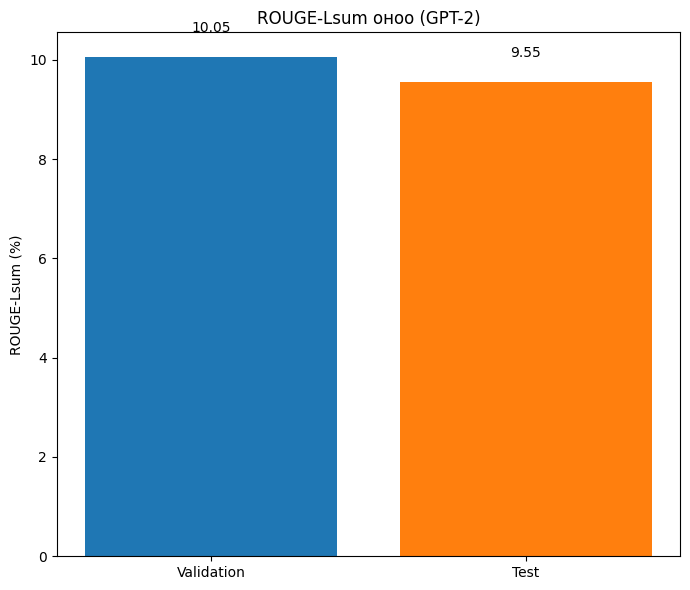

In [ ]:
# STEP 4 — Evaluate on validation & test, then plot ROUGE-Lsum for both

# Installs (safe to re-run)
!pip -q install evaluate rouge-score > /dev/null

import torch, math
import matplotlib.pyplot as plt

# Try to reuse existing objects; define fallbacks if missing
try:
    ds
except NameError:
    from datasets import load_dataset
    DATASET_NAME = "amaraaa/mn_translated_cnn_extended"
    ds = load_dataset(DATASET_NAME)

assert 'tokenizer' in globals(), "tokenizer is not defined in this runtime."
assert 'model' in globals(), "model is not defined in this runtime."

# Ensure left padding for decoder-only generation
tokenizer.padding_side = "left"
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

try:
    PROMPT_TEMPLATE
except NameError:
    INSTRUCTION = "Дараах бичвэрийг хураангуйлж бич."
    PROMPT_TEMPLATE = "### Даалгавар:\n" + INSTRUCTION + "\n\n### Бичвэр:\n{article}\n\n### Хураангуй:\n"

try:
    SOURCE_MAX_TOK
except NameError:
    MAX_SEQ_LEN = getattr(model.config, "n_positions", 1024) or 1024
    GEN_MAX_TOK = 160
    SOURCE_MAX_TOK = MAX_SEQ_LEN - GEN_MAX_TOK

GEN_NEW_TOKENS = 160
NUM_BEAMS = 4

def _join_highlights(x):
    if isinstance(x, list):
        return " ".join([s.strip() for s in x if isinstance(s, str) and s.strip()])
    return str(x) if x is not None else ""

def build_prompt(article: str) -> str:
    return PROMPT_TEMPLATE.format(article=str(article).strip())

# ----- Generation helper (batched) -----
def generate_summaries(articles, batch_size=4):
    preds = []
    model.eval()
    for i in range(0, len(articles), batch_size):
        batch_articles = articles[i:i+batch_size]
        enc = tokenizer(
            [build_prompt(a) for a in batch_articles],
            padding=True,
            truncation=True,
            max_length=SOURCE_MAX_TOK,
            add_special_tokens=False,
            return_tensors="pt",
        )
        input_ids = enc["input_ids"].to(model.device)
        attention_mask = enc["attention_mask"].to(model.device)

        with torch.no_grad():
            gen_out = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=GEN_NEW_TOKENS,
                num_beams=NUM_BEAMS,
                do_sample=False,
                no_repeat_ngram_size=3,
                length_penalty=1.0,
                early_stopping=True,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )

        # Slice off the prompt (left padding-aware)
        input_lengths = attention_mask.sum(dim=1).tolist()
        for j in range(gen_out.size(0)):
            cont = gen_out[j, input_lengths[j]:]
            text = tokenizer.decode(cont, skip_special_tokens=True).strip()
            preds.append(text)
    return preds

# ----- ROUGE-Lsum with fallback -----
def compute_rouge_lsum(preds, refs):
    # Prefer evaluate (Hugging Face) if available; otherwise use rouge-score directly.
    try:
        import evaluate
        metric = evaluate.load("rouge")
        out = metric.compute(predictions=preds, references=refs, use_stemmer=True)
        return {
            "rouge1": round(out["rouge1"] * 100, 2),
            "rouge2": round(out["rouge2"] * 100, 2),
            "rougeL": round(out["rougeL"] * 100, 2),
            "rougeLsum": round(out["rougeLsum"] * 100, 2),
        }
    except Exception:
        # Local fallback: rouge-score
        from rouge_score import rouge_scorer, scoring
        scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
        agg = scoring.BootstrapAggregator()
        n = min(len(preds), len(refs))
        for p, r in zip(preds[:n], refs[:n]):
            agg.add_scores(scorer.score(r, p))  # (reference, prediction)
        res = agg.aggregate()
        return {
            "rouge1": round(res["rouge1"].mid.fmeasure * 100, 2),
            "rouge2": round(res["rouge2"].mid.fmeasure * 100, 2),
            "rougeL": round(res["rougeLsum"].mid.fmeasure * 100, 2),   # note: rouge-score exposes Lsum only; keep both for display
            "rougeLsum": round(res["rougeLsum"].mid.fmeasure * 100, 2),
        }

def evaluate_split(split_name, max_eval=None):
    assert split_name in ds, f"Split '{split_name}' not found. Available: {list(ds.keys())}"
    subset = ds[split_name]
    if max_eval is not None:
        subset = subset.select(range(min(max_eval, len(subset))))
    articles = [ex["article"] for ex in subset]
    refs = [_join_highlights(ex["highlights"]) for ex in subset]
    preds = generate_summaries(articles, batch_size=4)
    n = min(len(preds), len(refs))
    metrics = compute_rouge_lsum(preds[:n], refs[:n])
    metrics["n_examples"] = n
    return metrics

# Evaluate
val_metrics  = evaluate_split("validation")
test_metrics = evaluate_split("test")

print("Validation:", val_metrics)
print("Test      :", test_metrics)

# Plot ROUGE-Lsum for both
labels = ["Validation", "Test"]
values = [val_metrics["rougeLsum"], test_metrics["rougeLsum"]]

plt.figure(figsize=(7, 6))
bar_colors = ['#1f77b4', '#ff7f0e'] # Different colors for distinction
plt.bar(labels, values, color=bar_colors)
plt.title("ROUGE-Lsum оноо (GPT-2)")
plt.ylabel("ROUGE-Lsum (%)")
for i, v in enumerate(values):
    plt.text(i, v + 0.5, f"{v:.2f}", ha="center")
plt.tight_layout()
plt.show()


In [ ]:
# --- Inference for a single article (works whether model is in memory or you restarted) ---

import torch, os, glob
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

MODEL_NAME    = "bayartsogt/mongolian-gpt2"
OUTPUT_DIR    = "/content/mn-gpt2-sum-lora"   # where you trained/saved checkpoints
GEN_NEW_TOKENS_DEFAULT = 160
NUM_BEAMS_DEFAULT      = 4

# 1) Reuse existing tokenizer/model if available; otherwise load base+LoRA from best checkpoint
def _ensure_model_and_tokenizer():
    global model, tokenizer

    model_ok = "model" in globals()
    tok_ok   = "tokenizer" in globals()

    if model_ok and tok_ok:
        return model, tokenizer

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
    tokenizer.padding_side = "left"
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Load base model
    dtype = torch.float16 if torch.cuda.is_available() else torch.float32
    base = AutoModelForCausalLM.from_pretrained(MODEL_NAME, torch_dtype=dtype)

    # Make base aware of tokenizer size (prevents id out-of-range)
    base.resize_token_embeddings(len(tokenizer))
    base.config.pad_token_id = tokenizer.pad_token_id
    base.config.use_cache = False
    base.config.attn_implementation = "eager"

    # Find best/last checkpoint directory that contains LoRA adapter files
    ckpt = None
    try:
        # If trainer is still in memory
        ckpt = trainer.state.best_model_checkpoint or OUTPUT_DIR
    except:
        ckpts = sorted(glob.glob(f"{OUTPUT_DIR}/checkpoint-*"), key=os.path.getmtime)
        ckpt = ckpts[-1] if ckpts else OUTPUT_DIR

    # Wrap base with LoRA adapters
    model = PeftModel.from_pretrained(base, ckpt)
    model.eval()
    return model, tokenizer

model, tokenizer = _ensure_model_and_tokenizer()

# 2) Prompt template (same as training)
INSTRUCTION = (
    "Дараах бичвэрийг хураангуйлж бич."
)
PROMPT_TEMPLATE = (
    "### Даалгавар:\n"
    f"{INSTRUCTION}\n\n"
    "### Бичвэр:\n{article}\n\n"
    "### Хураангуй:\n"
)

# Respect GPT-2 context (1024)
MAX_CTX = getattr(model.config, "n_positions", 1024) or 1024

def build_prompt(article: str) -> str:
    return PROMPT_TEMPLATE.format(article=str(article).strip())

@torch.inference_mode()
def summarize(
    article: str,
    mode: str = "beam",              # 'beam' (deterministic) or 'sample' (diverse)
    max_new_tokens: int = GEN_NEW_TOKENS_DEFAULT,
    num_beams: int = NUM_BEAMS_DEFAULT,
    temperature: float = 0.7,
    top_p: float = 0.9,
    top_k: int = 50,
    no_repeat_ngram_size: int = 3,
    length_penalty: float = 1.0,
):
    # Encode only the prompt; left padding is enabled
    prompt = build_prompt(article)
    enc = tokenizer(
        prompt,
        padding=False,
        truncation=True,                 # truncate prompt if needed
        max_length=MAX_CTX - 1,          # leave at least 1 token for continuation
        add_special_tokens=False,
        return_tensors="pt",
    )
    input_ids      = enc["input_ids"].to(model.device)
    attention_mask = enc["attention_mask"].to(model.device)

    # Cap generation length to avoid exceeding context
    input_len = int(attention_mask.sum())
    safe_max_new = max(1, min(max_new_tokens, MAX_CTX - input_len - 1))

    gen_kwargs = dict(
        max_new_tokens=safe_max_new,
        no_repeat_ngram_size=no_repeat_ngram_size,
        length_penalty=length_penalty,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    if mode == "beam":
        gen_kwargs.update(dict(do_sample=False, num_beams=num_beams))
    elif mode == "sample":
        gen_kwargs.update(dict(
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            num_beams=1,
        ))
    else:
        raise ValueError("mode must be 'beam' or 'sample'")

    out = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        **gen_kwargs,
    )

    # Slice off the prompt (left padding-aware)
    continuation = out[0, input_len:]
    text = tokenizer.decode(continuation, skip_special_tokens=True).strip()
    return text

# 3) Try it with your own article text here
article_text = """Монголын Боловсол шинжлэх ухааны үйлдвэрчний эвлэлийн холбооны дарга З.Цогтгэрэл өнөөдөр /2025.09.23/ мэдэгдэл хийлээ. Энэ үеэрээ улс орон даяар маргааш /2025.09.24/ багш нарын цалинг 3.5 сая төгрөг болгохыг шаардан багш нар жагсах болсныг мэдэгдэв. Энэ үеэр багш нарын цалин хөлс, нийгмийн баталгааг сайжруулахыг шаардаж УИХ-ын дарга болон Ерөнхий сайд нарт шаардлага хүргүүлнэ. Уг шаардлагыг албан тушаалтнууд өөрийн биеэр хүлээн авахыг хүсэж байна. Мөн тайван жагсаал хийхдээ бусдын нэр хүндэд халдахгүй байхыг уриаллаа. Энэ удаагийн тайван жагсаал үр дүнд хүрэхгүй тохиолдолд хуулийнхаа хүрээнд тэмцэл хөдөлгөөнийг үргэлжлүүлэх болно гэв. Тайван жагсаалыг 12:00-16:00 цагийн хооронд зохион байгуулах юм. Багш нарын цалин хөлсийг нэмэгдүүлэх шаардлагыг тус холбооноос тавьж, улмаар Боловсролын яамныхантай хэлцэлд ч орсон. Боловсролын сайд П.Наранбаяр “Багш нарын үндсэн цалинг 3.5 сая төгрөг болгон нэмэгдүүлэхэд 3.3 их наяд төгрөг шаардлагатай. Энэ эх үүсвэрийг ирэх онд гаргах боломжгүй. Үе шаттай багш нарын цалинг нэмэх боломж бий” гэж мэдэгдээд байгаа."""

print("\n--- Beam search (deterministic) ---")
print(summarize(article_text, mode="beam", max_new_tokens=160, num_beams=4))

print("\n--- Sampling (more diverse) ---")
print(summarize(article_text, mode="sample", max_new_tokens=160, temperature=0.7, top_p=0.9, top_k=50))



--- Beam search (deterministic) ---


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Багш нарын цалингийн нэмэгдлийн талаар МҮЭХ-ны ерөнхийлөгч Х.Амгаланбаатар хэлэхдээ: "Багш нарын цалин, нийгмийн баталгааны тухай хуулиар багш нарын цалингийн нэмэгдүүлэлт нь инфляцийн түвшин, цалин хөлсний өсөлттэй уялдана. Энэ нь инфляцийн түвшний өөрчлөлттэй уялдана" гэж мэдэгдэв.
Багшийн хөдөлмөрийн хөлсний доод хэмжээгээр цалин нэмэх нь инфляцийн түвшингээс бага хувьтай уялдана гэж үзэж байна. Энэ асуудлаар үйлдвэрчний эвлэлийн дарга Б.Батзориг: "Хүүхдүүдийн үндсэн цалинг 2.5 саяас эхлэн нэмэгдүүлэх боломжтой гэж үзэж байгаа. Энэ тохиолдолд инфляцийн түвшин нь 1.1 сая төгрөг хүртэл нэмэх боломжтой" гэж мэдэгдлээ.
МҮЭХ-ны дарга: "Энэ асуудлаар МҮЭХ-нд хандаж болно" гэж хэлэв. Тэрээр хэлэхдээ: МҮЭХ-ноос Хөдөлмөрийн хөлсний доод хэмжээг инфляцийн түвшинтэй уялдуулж нэмэх нь зүйтэй гэж үзэж байгаагаа илэрхийлж байна.
Багш нар цалингийн нэмэгдлийг инфляцийн түвшинтэй уялдуулна

--- Sampling (more diverse) ---
Багш нарын цалинг нэмэгдүүлэх нь нийгэмд сөрөг нөлөө үзүүлж болзошгүй. Багш н

# Merge & Push to repo

In [ ]:
# Best checkpoint chosen during training
best_ckpt = trainer.state.best_model_checkpoint or "/content/mn-gpt2-sum-lora"
print("Using checkpoint:", best_ckpt)


Using checkpoint: /content/mn-gpt2-sum-lora/checkpoint-472


In [ ]:
import torch
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# 1) Load the trained PEFT model from best_ckpt
peft_model = AutoPeftModelForCausalLM.from_pretrained(
    best_ckpt,
    torch_dtype=dtype,
)

# 2) Merge LoRA weights into a vanilla CausalLM model and drop adapter hooks
merged_model = peft_model.merge_and_unload()
# Safety: keep eager attention and correct pad/eos
merged_model.config.attn_implementation = "eager"
merged_model.config.pad_token_id = tokenizer.pad_token_id
merged_model.config.eos_token_id = tokenizer.eos_token_id

# 3) Ensure tokenizer length matches model vocab (no-op if already equal)
merged_model.resize_token_embeddings(len(tokenizer))

# 4) Save locally (safetensors) with a generation_config tuned for your task
MERGED_DIR = "/content/mn-gpt2-sum-merged-v1"
gen_cfg = GenerationConfig(
    max_new_tokens=160,
    num_beams=4,
    do_sample=False,
    no_repeat_ngram_size=3,
    length_penalty=1.0,
    early_stopping=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

merged_model.save_pretrained(MERGED_DIR, safe_serialization=True)
tokenizer.save_pretrained(MERGED_DIR)
gen_cfg.save_pretrained(MERGED_DIR)

print("Merged model saved to:", MERGED_DIR)


Merged model saved to: /content/mn-gpt2-sum-merged-v1


In [ ]:
from huggingface_hub import login
login()  # paste your HF token when prompted (Settings -> Access Tokens)

REMOTE_REPO = "amaraaa/gpt2-summarization-mn-v1"  # change if you prefer another name

# Push model, tokenizer, and generation_config
merged_model.push_to_hub(REMOTE_REPO)
tokenizer.push_to_hub(REMOTE_REPO)

# (generation_config.json is included when saved via save_pretrained and repo contains it)
print("Pushed to:", REMOTE_REPO)


README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...9vu2af5/model.safetensors:   0%|          |  524kB /  249MB            

Pushed to: amaraaa/gpt2-summarization-mn-v1


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_base = "amaraaa/gpt2-summarization-mn-v1"

tok = AutoTokenizer.from_pretrained(model_base, use_fast=True)
tok.padding_side = "left"
if tok.pad_token is None:
    tok.pad_token = tok.eos_token

mdl = AutoModelForCausalLM.from_pretrained(model_base, torch_dtype=dtype)
mdl.config.attn_implementation = "eager"
mdl.eval().to("cuda" if torch.cuda.is_available() else "cpu")

def summarize(article: str, max_new_tokens=160):
    prompt = PROMPT_TEMPLATE.format(article=article)
    # Tokenize prompt and respect context budget (<= 1024)
    ids = tok(prompt, add_special_tokens=False, return_tensors="pt", truncation=True, max_length=1024 - max_new_tokens)
    ids = {k: v.to(mdl.device) for k, v in ids.items()}
    with torch.no_grad():
        out = mdl.generate(
            **ids,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            do_sample=False,
            no_repeat_ngram_size=3,
            length_penalty=1.0,
            early_stopping=True,
            pad_token_id=tok.pad_token_id,
            eos_token_id=tok.eos_token_id,
        )
    text = tok.decode(out[0], skip_special_tokens=True)
    # Return only the part after "### Хураангуй:\n"
    split_key = "### Хураангуй:\n"
    # return text.split(split_key, 1)
    return text.split(split_key, 1)[-1].strip()

test_article = "Монголын Боловсол шинжлэх ухааны үйлдвэрчний эвлэлийн холбооны дарга З.Цогтгэрэл өнөөдөр /2025.09.23/ мэдэгдэл хийлээ. Энэ үеэрээ улс орон даяар маргааш /2025.09.24/ багш нарын цалинг 3.5 сая төгрөг болгохыг шаардан багш нар жагсах болсныг мэдэгдэв. Энэ үеэр багш нарын цалин хөлс, нийгмийн баталгааг сайжруулахыг шаардаж УИХ-ын дарга болон Ерөнхий сайд нарт шаардлага хүргүүлнэ. Уг шаардлагыг албан тушаалтнууд өөрийн биеэр хүлээн авахыг хүсэж байна. Мөн тайван жагсаал хийхдээ бусдын нэр хүндэд халдахгүй байхыг уриаллаа. Энэ удаагийн тайван жагсаал үр дүнд хүрэхгүй тохиолдолд хуулийнхаа хүрээнд тэмцэл хөдөлгөөнийг үргэлжлүүлэх болно гэв. Тайван жагсаалыг 12:00-16:00 цагийн хооронд зохион байгуулах юм. Багш нарын цалин хөлсийг нэмэгдүүлэх шаардлагыг тус холбооноос тавьж, улмаар Боловсролын яамныхантай хэлцэлд ч орсон. Боловсролын сайд П.Наранбаяр “Багш нарын үндсэн цалинг 3.5 сая төгрөг болгон нэмэгдүүлэхэд 3.3 их наяд төгрөг шаардлагатай. Энэ эх үүсвэрийг ирэх онд гаргах боломжгүй. Үе шаттай багш нарын цалинг нэмэх боломж бий” гэж мэдэгдээд байгаа."
print(summarize(test_article)[:400])


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/249M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

Багш нарын цалингийн нэмэгдлийн талаар МҮЭХ-ны ерөнхийлөгч Х.Амгаланбаатар хэлэхдээ: "Багш нарын цалин, нийгмийн баталгааны тухай хуулиар багш нарын цалингийн нэмэгдүүлэлт нь инфляцийн түвшин, цалин хөлсний өсөлттэй уялдана. Энэ нь инфляцийн түвшний өөрчлөлттэй уялдана" гэж мэдэгдэв.
Багшийн хөдөлмөрийн хөлсний доод хэмжээгээр цалин авдаг багш нарын хувьд цалингийн нэмэгдлийг инфляцийн төвшинтэй у


# Graph үүсгэх

In [ ]:
!pip -q install -U "transformers>=4.44.0" "datasets>=2.19.0" "evaluate>=0.4.2" "rouge-score>=0.1.2" "accelerate>=0.34.0"

import torch, random, numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_ID   = "amaraaa/gpt2-summarization-mn-v1"
DATASET_ID = "amaraaa/mn_translated_cnn_extended"

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else (torch.float16 if torch.cuda.is_available() else torch.float32)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 20.9 MB/s eta 0:00:00


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True)
tokenizer.padding_side = "left"
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=dtype)
model.config.attn_implementation = "eager"
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.eval().to(device)

max_context = getattr(model.config, "max_position_embeddings", 1024)

INSTRUCTION = "Дараах бичвэрийг хураангуйлж бич."
PROMPT_TEMPLATE = (
    "### Даалгавар:\n"
    f"{INSTRUCTION}\n\n"
    "### Бичвэр:\n{article}\n\n"
    "### Хураангуй:\n"
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/249M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

In [ ]:
from datasets import load_dataset
import evaluate

rouge = evaluate.load("rouge")

def join_highlights(x):
    if isinstance(x, list):
        return " ".join([s.strip() for s in x if isinstance(s, str) and s.strip()])
    return str(x).strip()

def build_prompt(article: str) -> str:
    return PROMPT_TEMPLATE.format(article=article.strip())

@torch.no_grad()
def generate_batch(prompts, max_new_tokens=160, num_beams=4, no_repeat_ngram_size=3, length_penalty=1.0):
    # Cap prompt length so prompt_len + max_new_tokens <= max_context
    enc = tokenizer(
        prompts,
        add_special_tokens=False,
        truncation=True,
        max_length=max_context - max_new_tokens,
        padding=True,
        return_tensors="pt",
    )
    enc = {k: v.to(device) for k, v in enc.items()}

    outputs = model.generate(
        **enc,
        max_new_tokens=max_new_tokens,
        num_beams=num_beams,
        do_sample=False,
        no_repeat_ngram_size=no_repeat_ngram_size,
        length_penalty=length_penalty,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # Strip the prompt back off, returning only the summary text
    summaries = []
    for p, full in zip(prompts, decoded):
        if full.startswith(p):
            summaries.append(full[len(p):].strip())
        else:
            # fallback: split on the summary marker
            key = "### Нэгтгэл:\n"
            summaries.append(full.split(key, 1)[-1].strip() if key in full else full.strip())
    return summaries

def evaluate_split(ds, split_name, batch_size=4, limit=None, max_new_tokens=160):
    if limit is not None:
        ds = ds.select(range(min(limit, len(ds))))

    preds, refs = [], []
    batch_prompts = []
    batch_refs = []

    for ex in ds:
        article = str(ex.get("article", "")).strip()
        summary = join_highlights(ex.get("highlights", []))
        batch_prompts.append(build_prompt(article))
        batch_refs.append(summary)

        if len(batch_prompts) == batch_size:
            preds.extend(generate_batch(batch_prompts, max_new_tokens=max_new_tokens))
            refs.extend(batch_refs)
            batch_prompts, batch_refs = [], []

    # leftover
    if batch_prompts:
        preds.extend(generate_batch(batch_prompts, max_new_tokens=max_new_tokens))
        refs.extend(batch_refs)

    preds = [p.strip() for p in preds]
    refs  = [r.strip() for r in refs]

    scores = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
    # Return as percentages with two decimals
    out = {k: round(v * 100, 2) for k, v in scores.items()}
    print(f"{split_name} — evaluated {len(refs)} examples. ROUGE:", out)
    return out


In [ ]:
ds = load_dataset(DATASET_ID)

# Optional quick smoke test first (set limit=100); for full eval set limit=None
VAL_LIMIT = None
TEST_LIMIT = None

val_scores = evaluate_split(ds["validation"], "Validation", batch_size=16, limit=VAL_LIMIT, max_new_tokens=160)
test_scores = evaluate_split(ds["test"], "Test", batch_size=16, limit=TEST_LIMIT, max_new_tokens=160)

val_rlsum = val_scores["rougeLsum"]
test_rlsum = test_scores["rougeLsum"]

import matplotlib.pyplot as plt

labels = ["Validation", "Test"]
values = [val_rlsum, test_rlsum]

plt.figure(figsize=(8,5))
bar_colors = ['#1f77b4', '#ff7f0e']
bars = plt.bar(labels, values, color=bar_colors)

for i, v in enumerate(values):
    plt.text(i, v + 0.1, f"{v:.2f}", ha="center", va="bottom", fontsize=10)
plt.title("ROUGE-Lsum Үнэлгээ (GPT-2)")
plt.ylabel("ROUGE-Lsum (%)")
plt.ylim(0, 20)
plt.tight_layout()
plt.savefig("/content/rouge_lsum_gpt2.png", dpi=160)
plt.show()

print("Saved plot to /content/rouge_lsum_gpt2.png")


Exception ignored in: <function _xla_gc_callback at 0x7b1396729300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/lib/__init__.py", line 127, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
